In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
# Load marineHeatWaves definition module
import marineHeatWaves as mhw
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import cftime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import glob
import math
import seaborn as sns
import cmcrameri.cm as cmc  # cmcrameri colormaps
import matplotlib.cm as cmm  # matplotlib colormaps
from pypalettes import load_cmap
from cmap import Colormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

### urchin data preparation

In [19]:
df_urchin = pd.read_csv('ep_m2_inverts_australia.csv', low_memory=False)
df_urchin = df_urchin[df_urchin.taxon.isin(['Centrostephanus rodgersii'])]  
# adjust time format
df_urchin['survey_date'] = pd.to_datetime(df_urchin['survey_date'], format='%Y-%m-%d')  #%d/%m/%Y
df_urchin['survey_year'] = df_urchin['survey_date'].dt.year
df_urchin = df_urchin[df_urchin.survey_year > 2012]
df_urchin = df_urchin[(df_urchin.longitude < 155)].reset_index() 
df_urchin.head()

,index,survey_id,country,area,ecoregion,realm,location,site_code,site_name,latitude,...,order,family,recorded_species_name,species_name,taxon,reporting_name,size_class,total,biomass,survey_year
0,30972,712300620,Australia,Victoria,Cape Howe,Temperate Australasia,Cape Howe,CHMP-S1,Howe Outer,-37.50853,...,Diadematoida,Diadematidae,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,0.0,43,NaN,2014
1,30977,712300621,Australia,Victoria,Cape Howe,Temperate Australasia,Cape Howe,CHMP-S1,Howe Outer,-37.50853,...,Diadematoida,Diadematidae,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,0.0,108,NaN,2014
2,30983,712300622,Australia,Victoria,Cape Howe,Temperate Australasia,Cape Howe,CHMP-S1,Howe Outer,-37.50853,...,Diadematoida,Diadematidae,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,0.0,64,NaN,2014
3,30986,712300623,Australia,Victoria,Cape Howe,Temperate Australasia,Cape Howe,CHMP-S1,Howe Outer,-37.50853,...,Diadematoida,Diadematidae,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,0.0,1,NaN,2014
4,30991,712300624,Australia,Victoria,Cape Howe,Temperate Australasia,Cape Howe,CHMP-S4,Gabo NE Gulch,-37.55320,...,Diadematoida,Diadematidae,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,Centrostephanus rodgersii,0.0,60,NaN,2014


In [20]:
df_urchin['number'] = df_urchin.total/50
df_urchin = df_urchin[['survey_id', 'location', 'site_code', 'site_name', 'latitude', 'longitude', 'survey_year', 'program', 'block', 'taxon', 'size_class', 'total', 'number']]
df_urchin

,survey_id,location,site_code,site_name,latitude,longitude,survey_year,program,block,taxon,size_class,total,number
0,712300620,Cape Howe,CHMP-S1,Howe Outer,-37.50853,149.97610,2014,Parks Vic,2,Centrostephanus rodgersii,0.0,43,0.86
1,712300621,Cape Howe,CHMP-S1,Howe Outer,-37.50853,149.97610,2014,Parks Vic,2,Centrostephanus rodgersii,0.0,108,2.16
2,712300622,Cape Howe,CHMP-S1,Howe Outer,-37.50853,149.97610,2014,Parks Vic,2,Centrostephanus rodgersii,0.0,64,1.28
3,712300623,Cape Howe,CHMP-S1,Howe Outer,-37.50853,149.97610,2014,Parks Vic,2,Centrostephanus rodgersii,0.0,1,0.02
4,712300624,Cape Howe,CHMP-S4,Gabo NE Gulch,-37.55320,149.91200,2014,Parks Vic,2,Centrostephanus rodgersii,0.0,60,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,923402791,Maria Island,MIR-S8,Magistrates Point South,-42.58626,148.05190,2023,ATRC,1,Centrostephanus rodgersii,15.0,2,0.04
4482,923402793,Maria Island,MIR-S7,Magistrates Point North,-42.58268,148.05460,2023,ATRC,1,Centrostephanus rodgersii,15.0,1,0.02
4483,923402799,Maria Island,MIR-S11,Ile du Nord,-42.56230,148.06735,2023,ATRC,1,Centrostephanus rodgersii,12.5,1,0.02
4484,923402803,Maria Island,MIR-S11,Ile du Nord,-42.56230,148.06735,2023,ATRC,1,Centrostephanus rodgersii,12.5,8,0.16


In [21]:
# average the latest decade
# get sum along the size_class for the same id, site, block
df_urchin_size = df_urchin.groupby(["survey_id", "location", "site_name", "latitude", "longitude", 'survey_year', "taxon", "block"]).sum(
                                        numeric_only = True).reset_index(
                                        level=["survey_id", "location", "site_name", "latitude", "longitude", 'survey_year', "taxon", "block"])
# average the block
df_urchin_block = df_urchin_size.groupby(["survey_id","location", "site_name", "latitude", "longitude", 'survey_year', "taxon"]).mean(
                                        numeric_only = True).reset_index(
                                        level=["survey_id", "location", "site_name", "latitude", "longitude", 'survey_year', "taxon"])
# sum the taxon, even though two species distributed in differnt places 
df_urchin_tax = df_urchin_block.groupby(["survey_id", "location","site_name", "latitude", "longitude", 'survey_year']).sum(numeric_only = True).reset_index(
                                        level=["survey_id", "location","site_name", "latitude", "longitude", 'survey_year'])
# average each id
df_urchin_id = df_urchin_tax.groupby(["location","site_name", "latitude", "longitude", 'survey_year']).mean(numeric_only = True).reset_index(
                                      level=["location","site_name", "latitude", "longitude", 'survey_year'])
# df_urchin_tax
# average the latest decade
df_urchin_decade = df_urchin_id.groupby(["location","site_name", "latitude", "longitude"]).mean(numeric_only = True).reset_index(
                                         level=['location', 'site_name', 'latitude', 'longitude'])
df_urchin_decade

,location,site_name,latitude,longitude,survey_year,survey_id,block,size_class,total,number
0,Batemans,Acron Ledge,-35.72030,150.24789,2017.000000,8.123312e+08,1.00,0.000,35.75,0.715
1,Batemans,Aragunnu Southern Bay,-36.58472,150.05333,2014.000000,9.123450e+08,1.50,0.000,160.00,3.200
2,Batemans,Barren Bommie,-36.13559,150.12916,2015.333333,9.123471e+08,1.50,0.000,131.50,2.630
3,Batemans,Belowla Island South West,-35.55425,150.38896,2017.000000,8.123312e+08,1.00,0.000,176.00,3.520
4,Batemans,Bingi Bingi Point,-36.01291,150.16603,2016.000000,9.123484e+08,1.25,6.875,8.00,0.160
...,...,...,...,...,...,...,...,...,...,...
336,Tasmania - South East,Variety Bay South,-43.20444,147.41701,2021.000000,9.234001e+08,1.00,12.500,1.00,0.020
337,Tasmania - South East,Waterfall Bay caves,-43.06304,147.95447,2014.000000,9.123441e+08,2.00,0.000,1.00,0.020
338,Victoria - North east,Bastion Point Mallacoota,-37.57328,149.76730,2013.000000,9.123430e+08,1.50,0.000,26.00,0.520
339,Victoria - North east,Betka River,-37.59055,149.74108,2014.000000,9.123446e+08,1.50,0.000,98.00,1.960


### urchin number histogram along lat

In [25]:
n_bins = 20
# Create an array from -25 to -45 for binning
latitude_bins = np.linspace(-45, -25, n_bins + 1)
# Create bins using the predefined latitude array
df_urchin_decade['bin'], bins = pd.cut(df_urchin_decade['latitude'], bins=latitude_bins, retbins=True, right=False)
all_bins = pd.DataFrame({'bin': pd.IntervalIndex.from_breaks(bins, closed='left')})
# all_bins

In [26]:
# urchin threshold for kelp collapse under three mhw conditions
threshold = [1.7, 2.4, 3.1]  # 1.7, 2.95, 4.05

In [27]:
# Categorize sites based on thresholds
df_urchin_decade['resilience_category'] = pd.cut(df_urchin_decade['number'], 
                                           bins=[-float('inf'), threshold[0], threshold[1], threshold[2], float('inf')], 
                                           labels=['Strong','Moderate', 'Low', 'None'])


In [28]:
df_urchin_decade 

,location,site_name,latitude,longitude,survey_year,survey_id,block,size_class,total,number,bin,resilience_category
0,Batemans,Acron Ledge,-35.72030,150.24789,2017.000000,8.123312e+08,1.00,0.000,35.75,0.715,"[-36.0, -35.0)",Strong
1,Batemans,Aragunnu Southern Bay,-36.58472,150.05333,2014.000000,9.123450e+08,1.50,0.000,160.00,3.200,"[-37.0, -36.0)",None
2,Batemans,Barren Bommie,-36.13559,150.12916,2015.333333,9.123471e+08,1.50,0.000,131.50,2.630,"[-37.0, -36.0)",Low
3,Batemans,Belowla Island South West,-35.55425,150.38896,2017.000000,8.123312e+08,1.00,0.000,176.00,3.520,"[-36.0, -35.0)",None
4,Batemans,Bingi Bingi Point,-36.01291,150.16603,2016.000000,9.123484e+08,1.25,6.875,8.00,0.160,"[-37.0, -36.0)",Strong
...,...,...,...,...,...,...,...,...,...,...,...,...
336,Tasmania - South East,Variety Bay South,-43.20444,147.41701,2021.000000,9.234001e+08,1.00,12.500,1.00,0.020,"[-44.0, -43.0)",Strong
337,Tasmania - South East,Waterfall Bay caves,-43.06304,147.95447,2014.000000,9.123441e+08,2.00,0.000,1.00,0.020,"[-44.0, -43.0)",Strong
338,Victoria - North east,Bastion Point Mallacoota,-37.57328,149.76730,2013.000000,9.123430e+08,1.50,0.000,26.00,0.520,"[-38.0, -37.0)",Strong
339,Victoria - North east,Betka River,-37.59055,149.74108,2014.000000,9.123446e+08,1.50,0.000,98.00,1.960,"[-38.0, -37.0)",Moderate


### urchin number histogram along lat

In [25]:
n_bins = 20
# Create an array from -25 to -45 for binning
latitude_bins = np.linspace(-45, -25, n_bins + 1)
# Create bins using the predefined latitude array
df_urchin_decade['bin'], bins = pd.cut(df_urchin_decade['latitude'], bins=latitude_bins, retbins=True, right=False)


In [26]:
# urchin threshold for kelp collapse under three mhw conditions
threshold = [1.7, 2.4, 3.1] 

In [27]:
# Categorize sites based on thresholds
df_urchin_decade['resilience_category'] = pd.cut(df_urchin_decade['number'], 
                                           bins=[-float('inf'), threshold[0], threshold[1], threshold[2], float('inf')], 
                                           labels=['Strong','Moderate', 'Low', 'None'])


In [29]:
## we want all possible categories (even if they have zero occurrences in some bins), use observed=False!
binned_df = df_urchin_decade.groupby(['bin', 'resilience_category'], 
                                     observed=False).size().unstack(fill_value=0).reset_index() 
df_number_binned = df_urchin_decade.groupby('bin', observed=False).max(numeric_only = True).reset_index()
df_number_binned
# Merge with all_bins to ensure all bins are present
binned_df = binned_df.merge(all_bins, on='bin', how='left').merge(df_number_binned[['bin', 'number']], on = 'bin', how = 'left')

In [30]:
binned_df['latitude'] = binned_df['bin'].apply(lambda x: x.mid).round(1)
binned_df

,bin,Strong,Moderate,Low,None,number,latitude
0,"[-45.0, -44.0)",0,0,0,0,NaN,-44.5
1,"[-44.0, -43.0)",22,0,1,0,3.100000,-43.5
2,"[-43.0, -42.0)",21,0,0,0,0.675000,-42.5
3,"[-42.0, -41.0)",15,2,0,0,1.760000,-41.5
4,"[-41.0, -40.0)",0,0,0,0,NaN,-40.5
5,"[-40.0, -39.0)",22,0,0,0,1.530833,-39.5
6,"[-39.0, -38.0)",0,0,0,0,NaN,-38.5
7,"[-38.0, -37.0)",19,1,0,0,1.960000,-37.5
8,"[-37.0, -36.0)",4,4,2,7,9.375000,-36.5
9,"[-36.0, -35.0)",35,18,19,15,10.365000,-35.5


In [31]:
cross_tab_prop = pd.crosstab(index=df_urchin_decade['bin'],
                             columns=df_urchin_decade['resilience_category'],
                             normalize="index")
# Reindex to include all bins, filling missing values with 0
cross_tab_prop = cross_tab_prop.reindex(binned_df['latitude'], fill_value=0)
cross_tab_prop

resilience_category,Strong,Moderate,Low,None
latitude,,,,
-44.5,0.000000,0.000000,0.000000,0.000000
-43.5,0.956522,0.000000,0.043478,0.000000
-42.5,1.000000,0.000000,0.000000,0.000000
-41.5,0.882353,0.117647,0.000000,0.000000
-40.5,0.000000,0.000000,0.000000,0.000000
-39.5,1.000000,0.000000,0.000000,0.000000
-38.5,0.000000,0.000000,0.000000,0.000000
-37.5,0.950000,0.050000,0.000000,0.000000
-36.5,0.235294,0.235294,0.117647,0.411765


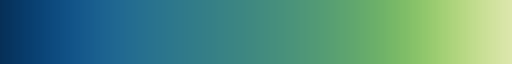

In [33]:
# base_cmap = sns.color_palette("ch:start=.2,rot=-.9", as_cmap=True)
colors = cmc.navia(np.linspace(0.1, 0.9, cmc.nuuk.N))
custom_cmap = mcolors.ListedColormap(colors)
custom_cmap

In [36]:
# Replace NaN values in 'number' column with zero
binned_df["number"] = binned_df["number"].fillna(0)
# Define the bar edges correctly
x_edges = np.concatenate(([binned_df.latitude[0] - 0.5], binned_df.latitude + 0.5, [binned_df.latitude.iloc[-1] + 0.5]))  # Extend left & right
y_edges = np.concatenate(([0], binned_df.number, [0]))  # Ensure matching dimensions
x_edges

array([-45., -44., -43., -42., -41., -40., -39., -38., -37., -36., -35.,
       -34., -33., -32., -31., -30., -29., -28., -27., -26., -25., -25.])

In [ ]:
def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap_gradual = truncate_colormap(cmc.navia, 0.1, 0.9)

In [41]:
df_urchin_decade = df_urchin_decade.sort_values(by=['number'])

[]

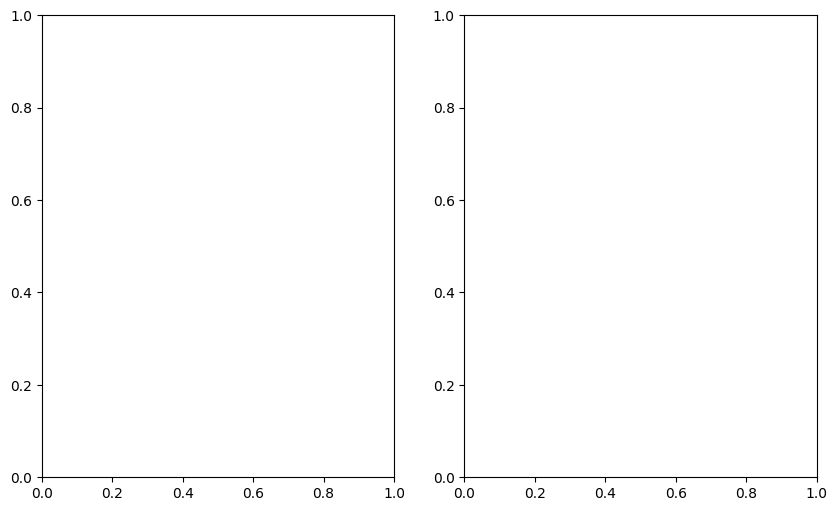

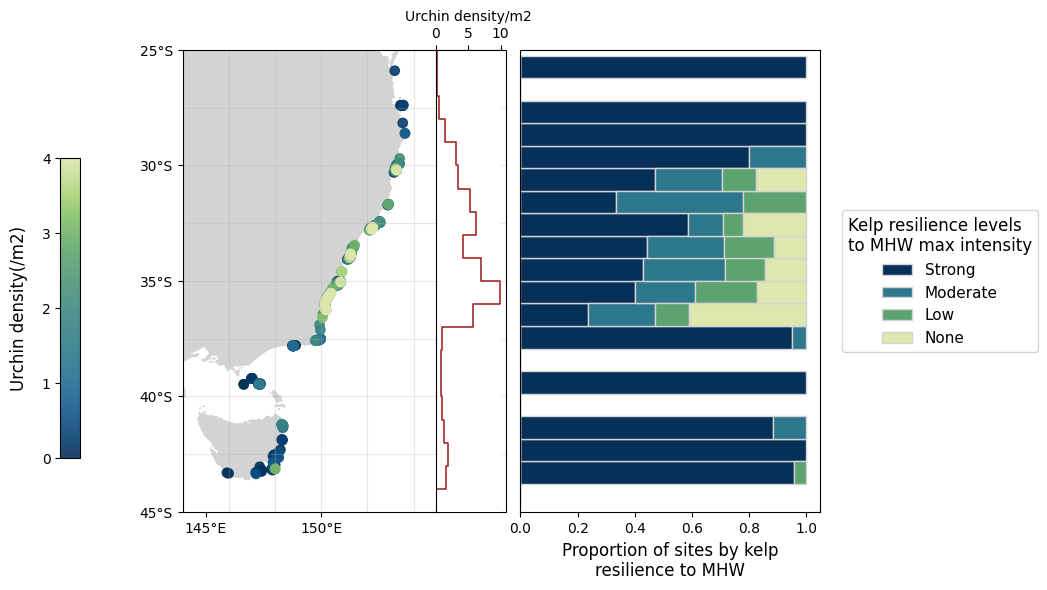

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()

# Add the first subplot with a projection
axs[0] = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree()) 
axs[1] = fig.add_subplot(1, 2, 2) 


# ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Plot the site locations with colormap based on scores
scatter = axs[0].scatter(np.array(df_urchin_decade.longitude), np.array(df_urchin_decade.latitude), 
                     c=df_urchin_decade.number , cmap=cmap_gradual, marker='o', s=45, vmin=0, vmax=4, transform=proj, alpha = 0.9) # cmap_disc

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.02, 0.2, 0.02, 0.5]) #[0.15, 0.02, 0.3, 0.025]
# Add the colorbar to the new axis
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical', pad=0.01)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_label('Urchin density(/m2)', fontsize=12, rotation=90, labelpad=10)
cbar.set_ticks(np.linspace(0, 4, num=5))
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels(ticklabs, fontsize=14)

# axs[0].coastlines()
axs[0].gridlines(alpha=0.3)
# ax1.add_feature(cfeature.OCEAN, facecolor='lightsteelblue')
axs[0].add_feature(cfeature.LAND, facecolor='lightgrey')

# Set the desired x and y range
lon_range = [144, 158]
lat_range = [-45, -25]

# Set the x and y axis limits
axs[0].set_xlim(lon_range)
axs[0].set_ylim(lat_range)
# Define the tick format functions
lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'S' if x < 0 else 'N'))
lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'W' if x < 0 else 'E'))
# Set the x and y tick positions and labels
axs[0].set_xticks(np.arange(145, 155, 5), crs=ccrs.PlateCarree())
axs[0].set_xticklabels([lon_formatter(x) for x in axs[0].get_xticks()], fontsize=10)
axs[0].set_yticks(np.arange(lat_range[0], lat_range[1]+1, 5), crs=ccrs.PlateCarree())
axs[0].set_yticklabels([lat_formatter(y) for y in axs[0].get_yticks()], fontsize=10)

## ===================================sketch a line =================================
divider = make_axes_locatable(axs[0])
ax_plot = divider.append_axes("right", size="20%", pad=-0.7, axes_class=plt.Axes)  # Size & spacing

# Plot the latitudinal outline
ax_plot.plot(y_edges, x_edges, drawstyle='steps-mid', color='brown', linewidth=1.2)
ax_plot.set_ylim([-45, -25])
ax_plot.set_xlabel("Urchin density/m2")
ax_plot.set_xlim([0, 10])
ax_plot.set_xticks([0, 5, 10])

# ax_plot.axis('off')
ax_plot.xaxis.set_ticks_position('top')
ax_plot.xaxis.set_label_position('top')
# ax_plot.spines['top'].set_visible(False)
ax_plot.spines['bottom'].set_visible(False)
ax_plot.spines['left'].set_visible(True)
ax_plot.spines['right'].set_visible(False)
# ax_plot.set_xticks([])
ax_plot.set_yticks([])
## ==================================================================================


# =================== Add the second subplot without a projection
axs[1].set_position([0.48, 0.11, 0.3, 0.77])
cross_tab_prop.plot(kind='barh', 
                    stacked=True, 
                    width=1, 
                    colormap=custom_cmap, #.reversed(),
                    edgecolor='lightgray', 
                    ax = axs[1])

axs[1].legend(loc="center right", ncol=1, bbox_to_anchor=(1.75, 0.5), fontsize = 11,
              title="Kelp resilience levels\nto MHW max intensity",  title_fontsize=12)
axs[1].set_xlabel("Proportion of sites by kelp\nresilience to MHW", fontsize = 12) # sea urchin grazing risk
axs[1].set_ylabel("")
axs[1].set_yticks([])
